/var/folders/x8/tfjs4htd20b9_gw42b2zzvxc0000gn/T/ipykernel_63955/2164375085.py:44: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(_daily_equal_short_weights)


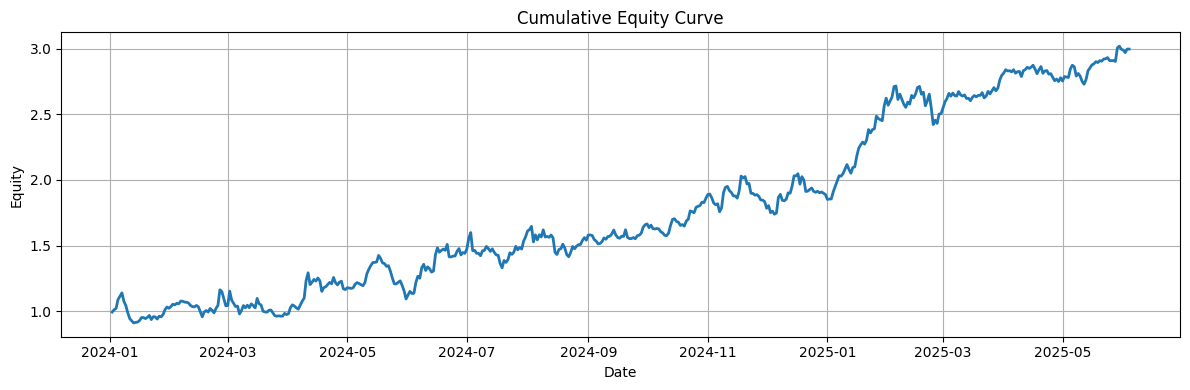

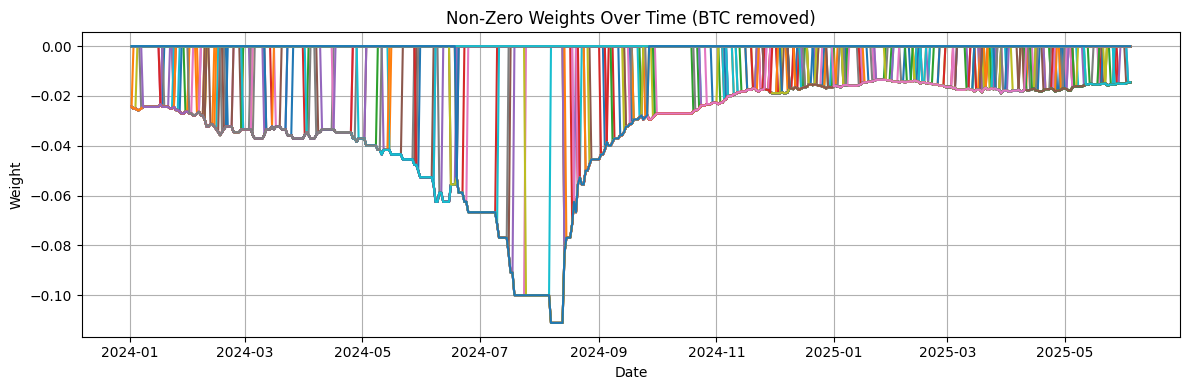

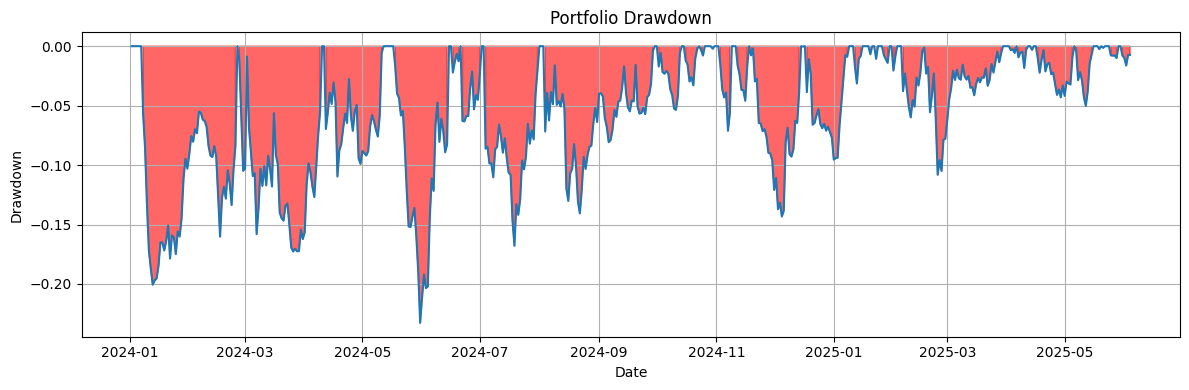

2.00 annualized Sharpe ratio
Volatility: 69.95%


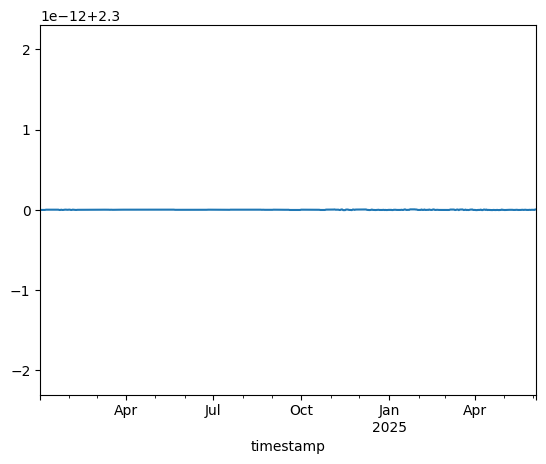

In [47]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

binance_path = "/Users/ilyat/Documents/quant📈/ccxt_data/data/binance/ohlc/perps/combined_enriched.csv"
bybit_path = "/Users/ilyat/Documents/quant📈/ccxt_data/data/bybit/ohlc/perps/combined_enriched.csv"
hyperliquid_path = "/Users/ilyat/Documents/quant📈/ccxt_data/data/hyperliquid/ohlc/perps/combined_enriched.csv"

df = pd.read_csv(binance_path)
df = df.sort_values(by=['timestamp'])
df.timestamp = pd.to_datetime(df.timestamp)

# 1) Compute each coin’s true days since listing (using its first-ever timestamp)
first_list = df.groupby('symbol')['timestamp'].transform('min')
df['days_since_list'] = (df['timestamp'] - first_list).dt.days
df['signal'] = np.where(df['days_since_list'] < 100, -1, 0)

# --- 1. Prep -----------------------------------------------------------------
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values(['timestamp', 'symbol'])

df = df[df.timestamp>'2024-01-01']

# --- 2. Compute daily pct returns -------------------------------------------
df['ret'] = df.groupby('symbol')['close'].pct_change()
# RET IS NOW THE RETURN from T-1 TO T
# THE WEIGHT IS DECIDED ON DAY T
# SO WE NEED TO LAG THE RETURNS BY ONE DAY TO BE FROM T TO T+1
# WE DO THIS WITH rets_lag = rets_df.shift(-1).fillna(0)

# --- 3. Equal-weight short signals ------------------------------------------
def _daily_equal_short_weights(day):
    shorts = day['signal'] == -1
    n = shorts.sum()
    if n > 0:
        return pd.Series(np.where(shorts, -1/n, 0.0), index=day.index)
    else:
        return pd.Series(0.0, index=day.index)

df['weight'] = (
    df.groupby('timestamp', group_keys=False)
      .apply(_daily_equal_short_weights)
)

# --- 4. Pivot weights & lagged returns -------------------------------------
weights_df = df.pivot(index='timestamp', columns='symbol', values='weight').fillna(0)
weights_df['BTC'] = 1.3
rets_df    = df.pivot(index='timestamp', columns='symbol', values='ret').fillna(0)

# lag returns by one period to avoid lookahead
rets_lag = rets_df.shift(-1).fillna(0)

# --- 5. Compute portfolio returns & equity ---------------------------------
port_ret = (weights_df * rets_lag).sum(axis=1).rename('port_ret')
equity = (1 + port_ret.cumsum()).rename('cum_equity')

# --- 6. Plot equity curve & non-zero weights in one figure -----------------
import matplotlib.pyplot as plt

# --- Plot 1: Cumulative Equity Curve ---------------------------------------
plt.figure(figsize=(12, 4))
plt.plot(equity.index, equity, lw=2)
plt.title('Cumulative Equity Curve')
plt.xlabel('Date')
plt.ylabel('Equity')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot 2: Non-Zero Weights Over Time (BTC removed) ----------------------
nz = (weights_df
      .drop(columns='BTC', errors='ignore')
      .loc[:, lambda x: (x != 0).any(axis=0)])

plt.figure(figsize=(12, 4))
for sym in nz.columns:
    plt.plot(nz.index, nz[sym])
plt.title('Non-Zero Weights Over Time (BTC removed)')
plt.xlabel('Date')
plt.ylabel('Weight')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot 3: Portfolio Drawdown --------------------------------------------
running_max = equity.cummax()
drawdown = (equity / running_max) - 1

plt.figure(figsize=(12, 4))
plt.fill_between(drawdown.index, drawdown, 0, where=drawdown < 0, color='red', alpha=0.6)
plt.plot(drawdown.index, drawdown, lw=1.5)
plt.title('Portfolio Drawdown')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"{(port_ret.mean()/port_ret.std())*np.sqrt(365):.2f} annualized Sharpe ratio")

weights_df.abs().sum(axis=1).plot()

print(f"Volatility: {port_ret.std() * np.sqrt(365):.2%}")


In [45]:
weights_df.iloc[-1][weights_df.iloc[-1] != 0].rename('weight').sort_values(ascending=False).round(4)

symbol
BTC       1.3000
A        -0.0145
OBOL     -0.0145
PROMPT   -0.0145
PORT3    -0.0145
           ...  
HAEDAL   -0.0145
HUMA     -0.0145
HYPE     -0.0145
HYPER    -0.0145
ZKJ      -0.0145
Name: weight, Length: 70, dtype: float64